This notebook is a demo of using a simulation with multiple actions.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy
from adaptive_nof1.models import Model, CombinedModel
from adaptive_nof1.basic_types import Outcome

RED_PILL = 1
BLUE_PILL = 2

class PillModel(Model):
    def __init__(self, patient_id):
        self.rng = numpy.random.default_rng(patient_id)
        self.red_pill_slope = self.rng.normal(0, 1)

    def generate_context(self, history):
        return {"time_of_the_day": numpy.sin(len(history) / 24 / 3)}

    def observe_outcome(self, action, context):
        if action == RED_PILL:
            return {"enlightment": context["time_of_the_day"] * self.red_pill_slope}
        else:
            return {"enlightment": self.rng.normal(0.3, 1)}

    def __str__(self):
        return f"PillModel"

## With the data generating model set, we can now set up a simulation study.
Let's say we want to compare the performance between a fixed allocation of red and blue pills and an epsilon-greedy bandit approach.

Let's first define some constants.


In [4]:
# Simulation constants
data_generating_model = lambda patient_id: CombinedModel([PillModel(patient_id), PillModel(patient_id)])

length = 200
number_of_actions = 2
number_of_patients = 10

Now, we create two series of simulations objects. We can use predefined policies.

In [6]:
from adaptive_nof1 import SeriesOfSimulations
from adaptive_nof1.policies import FixedPolicy, FrequentistEpsilonGreedy, CombinedPolicy

fixed_schedule_series = SeriesOfSimulations(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=CombinedPolicy([FixedPolicy(number_of_actions=number_of_actions),FixedPolicy(number_of_actions=number_of_actions)], number_of_actions=number_of_actions),
    length=length,
)

adaptive_series = SeriesOfSimulations(
    model_from_patient_id=data_generating_model,
    n_patients=number_of_patients,
    policy=FrequentistEpsilonGreedy(
        number_of_actions=number_of_actions, outcome_name="enlightment", epsilon=0.2
    ),
    length=length,
)

  0%|          | 0/200 [00:00<?, ?it/s]

KeyError: 'time_of_the_day'

The framework provides different plots to test the performance. One simple one is the regret over time graph:

In [9]:
from adaptive_nof1.metrics import SimpleRegret

SeriesOfSimulations.plot_lines([fixed_schedule_series, adaptive_series], SimpleRegret())

KeyError: 'outcome'

Additionally, one can look at each individual assignment:
If you hover over this graphic, you get detailed information about the assignment, including the counterfactual outcomes if another action would have been chosen.
Try it out yourself!

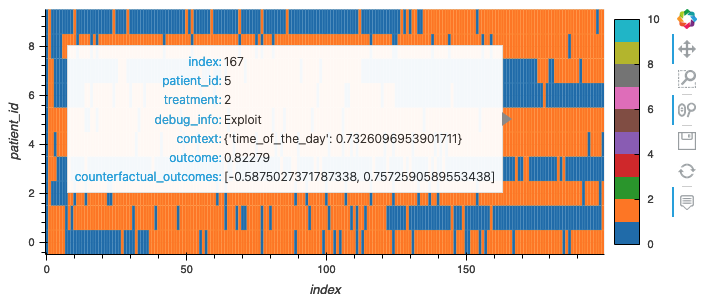

In [11]:
adaptive_series.plot_allocations()

HoloViews(HeatMap, height=300, sizing_mode='fixed', width=700)

There are many more policies, metrics, and models to explore. You can find an overview in the respective '\_\_init__.py' files in the folders, which include the different policies.